In [1]:
m=10

10

In [2]:
] activate .

  Activating project at `~/workspace`


In [3]:
using Plots

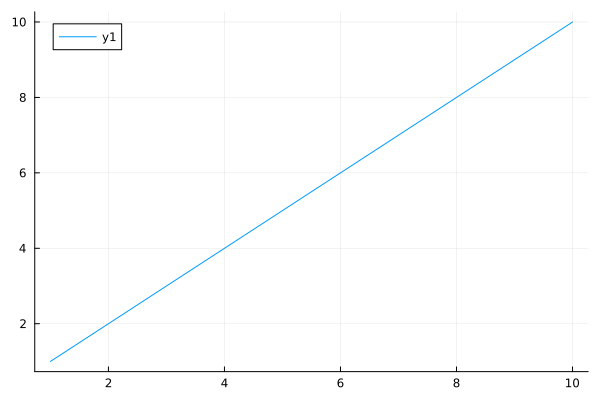

In [4]:
plot(1:10)

In [30]:
module bench

using Distributions
using Random
using DataFrames
using StatsPlots  
using BenchmarkTools

function sdata(k,n; doplot = false)
    Random.seed!(3333)
    # true values
    μ = [2.0,5.0]
    σ = [0.5,0.7]
    α = [0.3,0.7]

    m = MixtureModel([Normal(μ[i], σ[i]) for i in 1:2], α)
    if doplot
        plot(
            plot(m,linewidth=2), 
            plot(m,linewidth=2, fill=(0,:red,0.5), components = false, title="Mixture"),dpi = 300
            )
        savefig("mixtures.png")
    end
    y = rand(m,n)

    return Dict(:y => y, :μ => μ, :σ => σ, :α => α)
end


function allbm()
    ns = [10_000,100_000,1_000_000,10_000_000]
    d = DataFrame(n = ns,jl = zeros(4),jlg = zeros(4),R = zeros(4),Rmix = zeros(4))
    for ni in ns
        r = bm(25,ni, doplot = ni==ns[1])
        d[d.n .== ni,:jl] = r[:jl]
        d[d.n .== ni,:jlg] = r[:jlg]
        d[d.n .== ni,:R] = r[:R]
        d[d.n .== ni,:Rmix] = r[:Rmix]
    end
    s = stack(d,2:5)
    pl = @df s scatter(:n, :value, group = :variable, 
                        yaxis = :log, xaxis = :log, legend = :topleft,
                        xlabel = "num of observations", 
                        ylabel = "seconds", dpi = 300)
    savefig("EM-bench.png")
    return (d,pl)
end

function bm(iters,N; doplot = false)
    alpha_tol = 0.1  # no convergence, hence big tol
    mu_tol    = 0.5  # no convergence, hence big tol
    tol       = 0.0005  # all algos should converge to same point
    d         = sdata(2,N,doplot = doplot)
    y         = d[:y]
    N         = length(y)
    #@info "true values" N=N μ=d[:μ] σ=d[:σ] α=d[:α]

    jl = bm_jl(y,iters = iters)
    # and time
    jl_t = @belapsed bm_jl($y,iters = $iters)
    @info "hand julia: $jl_t seconds"

    # check outputs

    # @assert all( isapprox.( jl[:α], d[:α] , atol = alpha_tol) )
    # @assert all( isapprox.( jl[:μ], d[:μ] , atol = mu_tol) )
    # @assert all( isapprox.( jl[:σ], d[:σ] , atol = mu_tol) )

    # @assert all( isapprox.( jl[:α], jlg.w , atol = tol) )
    # @assert all( isapprox.( jl[:μ], jlg.μ , atol = tol) )
    # @assert all( isapprox.( jl[:σ], sqrt.(jlg.Σ) , atol = tol) )

    # @assert all( jl[:α] .≈ R[:result][:alpha] )
    # @assert all( jl[:μ] .≈ R[:result][:mu] )
    # @assert all( jl[:σ] .≈ R[:result][:sigma] )

    # @assert all( isapprox.( jl[:α] , Rm[:result][:lambda] , atol = tol))
    # @assert all( isapprox.( jl[:μ] , Rm[:result][:mu] , atol = tol))
    # @assert all( isapprox.( jl[:σ] , Rm[:result][:sigma] , atol = tol))

    return Dict(:jl => jl_t)
end


# Naive julia hand implementation

function logsumexp(x::Matrix{Float64})
    vm = maximum(x,dims = 2)
    log.( sum( exp.( x .- vm ), dims= 2 )) .+ vm
end

function bm_jl(y::Vector{Float64};iters=100)

    # poor starting values
    μ = [4.0,6.0]
    σ = [1.0,1.0]
    α = [0.5,0.5]

    N = length(y)
    K = length(μ)

    # initialize objects    
    L = zeros(N,K)
    p = similar(L)

    for it in 1:iters

        dists = [Normal(μ[ik], σ[ik] ) for ik in 1:K]

        # evaluate likelihood for each type 
        for i in 1:N
            for k in 1:K
                # Distributions.jl logpdf()
                L[i,k] = log(α[k]) + logpdf.(dists[k], y[i]) 
            end
        end

        # get posterior of each type 
        p[:,:] = exp.(L .- logsumexp(L))
      
        # with p in hand, update 
        α[:] .= vec(sum(p,dims=1) ./ N)
        μ[:] .= vec(sum(p .* y, dims = 1) ./ sum(p, dims = 1))
        σ[:] .= vec(sqrt.(sum(p .* (y .- μ').^2, dims = 1) ./ sum(p, dims = 1)))
    end
    return Dict(:α => α, :μ => μ, :σ => σ)
end

end

Main.bench

In [31]:
bench.bm(20, 10_000)

[ Info: hand julia: 0.01607775 seconds


Dict{Symbol, Float64} with 1 entry:
  :jl => 0.0160777